In [29]:
print("      ")

### Feature Based Image Alignment using OpenCV

Image alignment (also known as image registration) is the technique of warping one image ( or sometimes both images ) so that the features in the two images line up perfectly.

Image alignment works based on HOMOGRAPHY (3*3 matrix with feature vectors) <br>

* Two images of a scene are related by a homography under two conditions.

1) The two images are that of a plane (e.g. sheet of paper, credit card etc.). <br>
2) The two images were acquired by rotating the camera about its optical axis. We take such images while generating panoramas.

* Minimum 4 corresponding points are mandatorily needed ==> COrresponding points are actual stable points between two images (based on pixels)
* Corresponding points are the same coordinates in both the images
* Homography matrix is calculated between the two corresponding points
* This homography matrix can be applied all over the pixels to change the perspective of the new image

#### Steps to find corresponding points
1) ORB feature detector is used (Oriented FAST and Rotated BRIEF). Feature detector has two parts <br>
 </t>a) Locator: Identifies points on the image that are stable under image transformations like translation (shift), scale (increase / decrease in size), and rotation. The locator finds the x, y coordinates of such points. The locator used by the ORB detector is called FAST

    b) Descriptor: Encodes the key points identified by the locator.Ideally, the same physical point in two images should have the same descriptor. ORB uses a modified version of the feature descriptor called BRISK.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

* Read template and scanned image

In [3]:
template = "./form.jpg"
im1 = cv2.imread(template, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

scanned_form = "./scanned-form.jpg"
im2 = cv2.imread(scanned_form, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

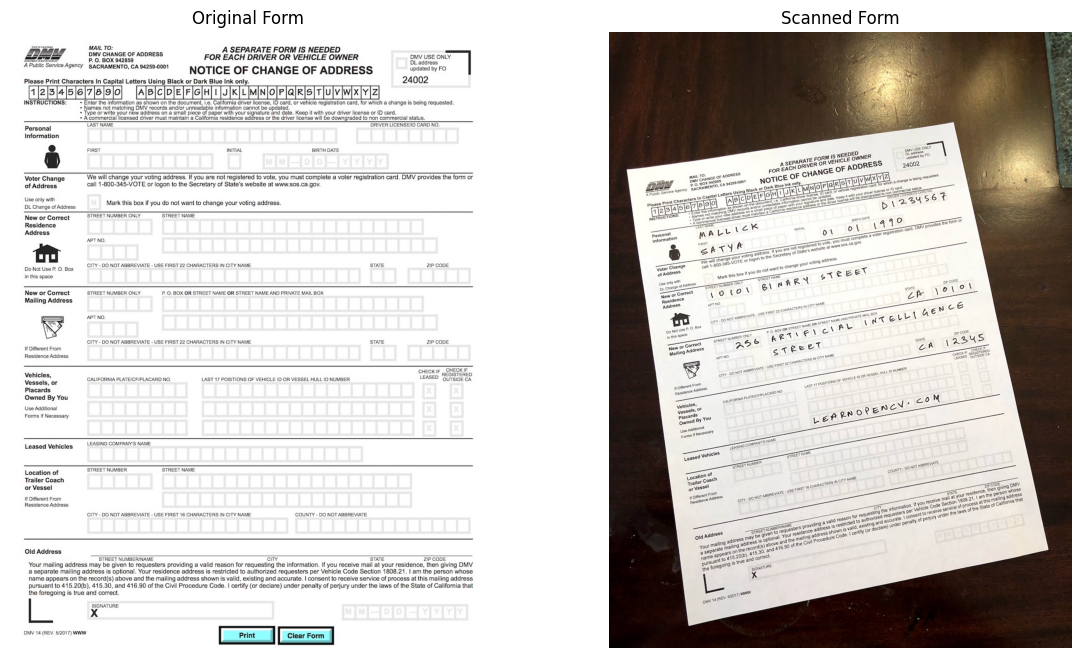

In [4]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(im1)
plt.title("Original Form")


plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(im2)
plt.title("Scanned Form")

plt.show()


#### Convert images to grey scale

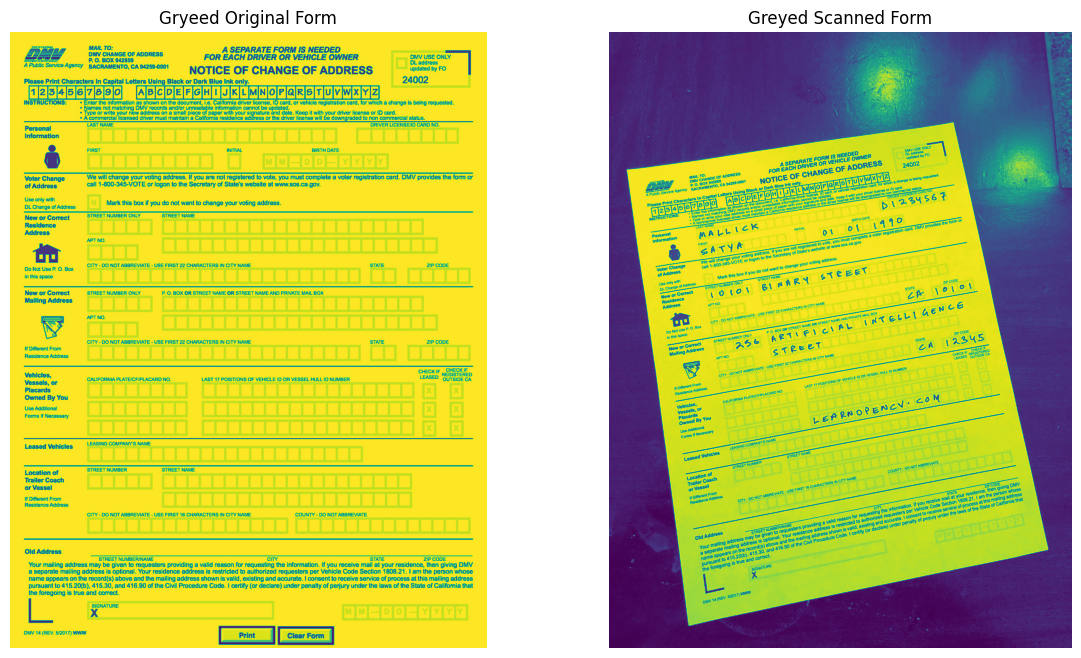

In [5]:
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(im1_gray)
plt.title("Gryeed Original Form")


plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(im2_gray)
plt.title("Greyed Scanned Form")

plt.show()


Detec ORB features - corresponding points (Locators & descriptors) <br>
<b> Keypoints - tries to find the edges, corners, texture based on pixel value </b>

In [22]:
MAX_NUM_FEATURES = 750
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

print(keypoints1[0:2], '\n', descriptors1[0:2])

(< cv2.KeyPoint 00000290AC1142A0>, < cv2.KeyPoint 00000290AC114210>) 
 [[ 20 246 190 179 226  96 179 206 250  95 123  55 116 250 106 106 227  91
   38 147 150 212 138 227  76 167 255 207 173  81 167 155]
 [160 150 219  84 118 105 225 254 219 190  60 110  96 249 237  14  59  98
    2 120  33 126 130 234  30  26 117 106 207 232  94 139]]


Visualize the keypoints

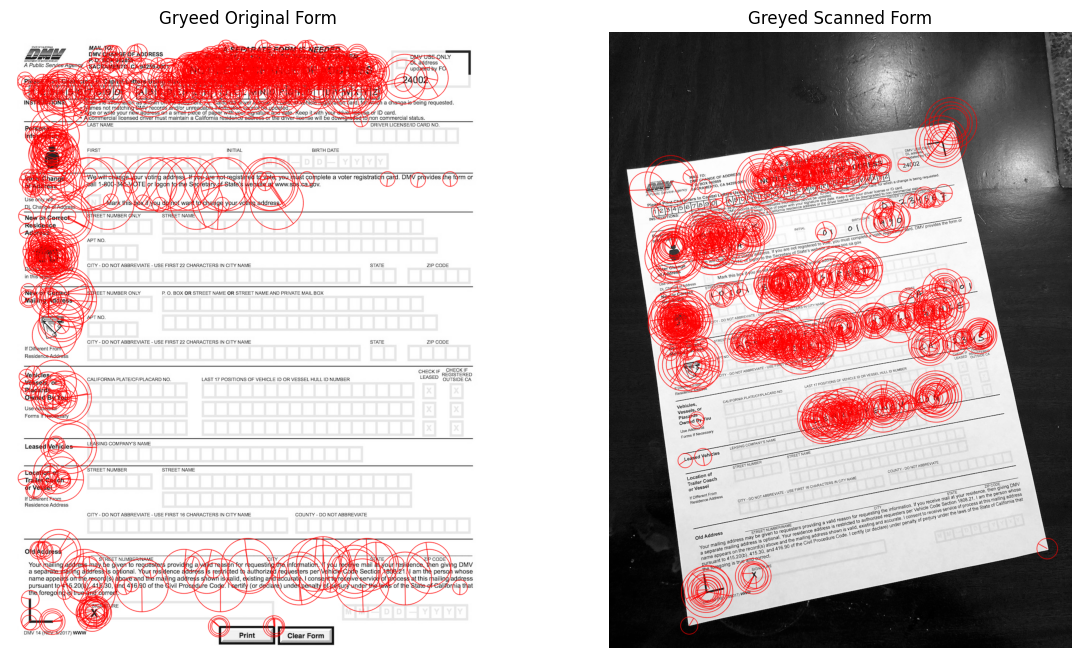

In [23]:
im1_display = cv2.drawKeypoints(im1_gray, keypoints1, outImage=np.array([]), color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2_gray, keypoints2, outImage=np.array([]), color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(im1_display)
plt.title("Gryeed Original Form")


plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(im2_display)
plt.title("Greyed Scanned Form")

plt.show()

Its okay to have false positive points, as we will consider better matching points(filter). <br>
Also, homography algorithm works in a robust way <br>

Descriptors are used to match the keypoints between tow imgaes and based on which the homography is calculated

* Match keypoints between the images

In [24]:
# Match feature
# Idea is to match the descriptors based on distance - less distance more match
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)
print(len(matches))
print(matches[0].distance)

matches = sorted(matches, key=lambda x: x.distance, reverse=False)
print(f'Minimum distance found {matches[0].distance}')
print(f'Maximum distance found {matches[-1].distance}')

#Lets keep the 1% of first initial datapoints in matches vector
numGoodmatches = int(len(matches) * 0.1)
print(numGoodmatches)
matches = matches[:numGoodmatches]

750
74.0
Minimum distance found 12.0
Maximum distance found 95.0
75


Visualize the top matches

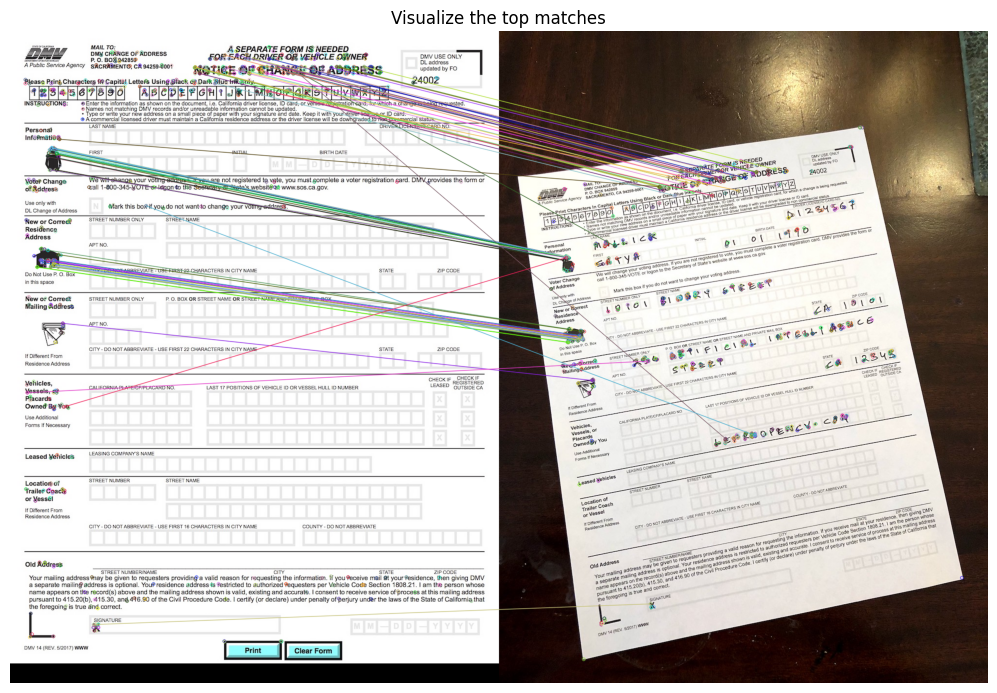

In [25]:
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=(20,30))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(im_matches)
plt.title("Visualize the top matches")
plt.tight_layout()

False positives are much reduced now

### Compute the Homography (3*3 matrix)

In [26]:
keypoints1[matches[0].queryIdx].pt

(89.16481018066406, 238.4640350341797)

In [27]:
#Extract locations of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
    
#Find homography using RANdom SAmple Consensus
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
print(f"Homography matrix is {h}")

Homography matrix is [[ 1.42161200e+00 -2.02302073e-01 -1.11149476e+01]
 [ 2.20817003e-01  1.52819433e+00 -4.82830864e+02]
 [-3.97278871e-05  1.33229795e-04  1.00000000e+00]]


#### Warp Image using the homography matrix => Image re-alignment

(1293, 1000, 3)


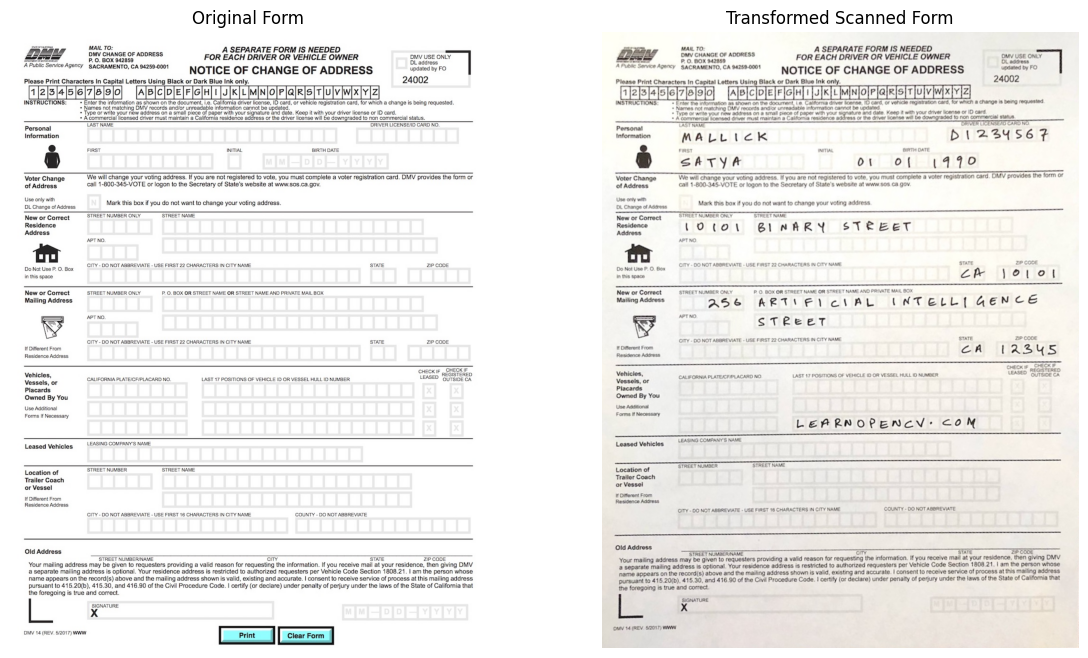

In [28]:
print(im1.shape)
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(im1)
plt.title("Original Form")


plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(im2_reg)
plt.title("Transformed Scanned Form")

plt.show()